## Config

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [3]:
df_train = pd.read_parquet('M3_yearly_processed.parquet')
df_eval = pd.read_parquet('M3_yearly_simple_forecasts.parquet')

## Official Evaluation Metrics
Five accuracy measures:
1. Symmetric MAPE

2. Average Ranking

3. Median symmetric APE

4. Median RAE

5. RMSE (root mean squared error)

Forecasting metrics calculations with assist of github repository:
https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

In [4]:
%run '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/forecasting_metrics.py'

#### NB! When using methods from this file nothing is multiplied with 100 for percentage operations!

In [5]:
actuals = np.array([900, 120, 138, 155, 149]) 
forecasts = np.array([1100, 124, 132, 141, 149]) 

### Symmetric MAPE (Mean Absolute Percentage Error)
The symmetric MAPE fluctuates between -200% and 200%

In [6]:
smape_val = smape(actuals, forecasts)
print(f'sMAPE: {smape_val * 100:.2f}%')

sMAPE: 7.44%


### Median Symmetric APE (median symmetric absolute percentage error)

In [7]:
symmetric_ape = smdape(actuals, forecasts)
print(f'sMAPE: {symmetric_ape * 100:.2f}%')

sMAPE: 4.44%


### Median RAE (relative absolute error)

In [8]:
mdrae_val = mdrae(actuals, forecasts)
print(f'MDRAE: {mdrae_val:.2f}')

MDRAE: 0.17


### RMSE (Root Mean Square Error)

In [9]:
rmse_val = rmse(actuals, forecasts)
print(f'RMSE: {rmse_val:.2f}')

RMSE: 89.72


## Evaluation

### Agregated

In [10]:
eval_ex1 = df_eval.loc[df_eval['Series'] == 1]
train_ex1 = df_train.loc[df_train['Series'] == 1]

#### Function that returns all eval metrics specified in competition

In [11]:
def all_eval_metrics(merged_df):
    """
    Calculate sMAPE, sMdAPE, MdRAE, and RMSE for each series within a merged DataFrame.
    
    Args:
    - merged_df (pd.DataFrame): DataFrame containing both actual and forecasted values, 
                                with 'Series', 'Date', 'Value' (actual), and 'TimeGPT' (forecast) columns.
    
    Returns:
    - pd.DataFrame: DataFrame containing the evaluation metrics for each series, along with the series identifier.
    """
    
    # Assuming the benchmark model is a naive model (last known value)
    # For simplicity, this function uses the last available 'Value' as the benchmark for all points in a series,
    # which might not perfectly align with Naïve2 if seasonality adjustments are required.
    
    results = []  # Initialize an empty list to store the results
    
    for series_id in merged_df['Series'].unique():
        series_data = merged_df[merged_df['Series'] == series_id]
        
        # Ensure there are no missing values in the series data for calculation
        if series_data.dropna(subset=['Value', 'TimeGPT']).empty:
            continue
        
        actuals = series_data['Value'].values
        forecasts = series_data['TimeGPT'].values
        
        # Simplified benchmark (naive forecast) calculation: using the last known value
        benchmark = np.full_like(actuals, actuals[-1])
        
        # Calculate metrics
        smape_val = smape(actuals, forecasts)
        smdape_val = mdape(actuals, forecasts)
        mdrae_val = mdrae(actuals, forecasts, benchmark)
        rmse_val = rmse(actuals, forecasts)
        
        results.append({
            'Series': series_id,
            'symmetric_MAPE': smape_val,
            'Median_APE': smdape_val,
            'Median_RAE': mdrae_val,
            'RMSE': rmse_val
        })
    
    # Convert the list of results to a DataFrame
    return pd.DataFrame(results)

In [12]:
df_merged = pd.merge(df_train, df_eval, on=['Series', 'Date'], how='left')

In [13]:
df_merged1 = df_merged.dropna(subset=['Value', 'TimeGPT'])

In [14]:
eval_metrics_df = all_eval_metrics(df_merged1)

In [15]:
print(eval_metrics_df.mean().apply(lambda x: f'{x:.2f}'))

Series                   323.00
symmetric_MAPE             0.24
Median_APE                 0.23
Median_RAE        3103526984.71
RMSE                    1593.61
dtype: object


### With time series steps

In [16]:
def eval_metrics_by_step(merged_df):
    """
    Calculate sMAPE, sMdAPE, MdRAE, and RMSE for each forecast step within each series.
    
    Args:
    - merged_df (pd.DataFrame): DataFrame containing both actual and forecasted values,
                                with 'Series', 'Date', 'Value' (actual), and 'TimeGPT' (forecast) columns.
    
    Returns:
    - pd.DataFrame: DataFrame containing the evaluation metrics for each forecast step within each series.
    """
    results = []  # Initialize an empty list to store the results
    
    for series_id in merged_df['Series'].unique():
        series_data = merged_df[merged_df['Series'] == series_id]
        
        # Calculate forecast horizon (assuming consecutive and complete forecast steps for each series)
        max_horizon = series_data.shape[0]
        
        # Iterate over each forecast step
        for step in range(1, max_horizon + 1):
            # For each step, select only rows up to the current forecast step
            step_data = series_data.head(step)
            
            # Check for sufficient data
            if step_data.dropna(subset=['Value', 'TimeGPT']).empty:
                continue
            
            actuals = step_data['Value'].values
            forecasts = step_data['TimeGPT'].values
            
            # Simplified benchmark calculation
            benchmark = np.full_like(actuals, actuals[-1])
            
            # Calculate metrics
            smape_val = smape(actuals, forecasts)
            smdape_val = mdape(actuals, forecasts)
            mdrae_val = mdrae(actuals, forecasts, benchmark)
            rmse_val = rmse(actuals, forecasts)
            
            results.append({
                'Series': series_id,
                'symmetric_MAPE': smape_val,
                'Median_APE': smdape_val,
                'Median_RAE': mdrae_val,
                'RMSE': rmse_val
            })
    
    # Convert the list of results to a DataFrame
    return pd.DataFrame(results)


In [17]:
step_wise = eval_metrics_by_step(df_merged1)


In [18]:
step_wise.head()

,Series,symmetric_MAPE,Median_APE,Median_RAE,RMSE
0,1,0.049135,0.047957,2.579956e+12,257.995605
1,1,0.130929,0.120115,5.920741e+12,856.962321
2,1,0.209179,0.192273,1.649461e+00,1412.834506
3,1,0.299526,0.250713,1.439518e+00,2129.439361
4,1,0.385484,0.309154,1.388347e+00,2768.711589


In [19]:
print(step_wise.mean().apply(lambda x: f'{x:.2f}'))

Series                      323.00
symmetric_MAPE                0.17
Median_APE                    0.17
Median_RAE        1598739399838.87
RMSE                       1064.17
dtype: object


## Evaluation of other methods used in the competition

### First agged by category

In [20]:
def read_all_sheets(excel_path):
    """
    Reads all sheets from an Excel file and combines them into a single DataFrame.
    
    Args:
    - excel_path (str): The path to the Excel file.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the combined data from all sheets.
    """
    # Use pandas to read the Excel file and get sheet names
    xls = pd.ExcelFile(excel_path)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        
        # Optionally, add a column to indicate the source sheet, if needed
        df['Sheet'] = sheet_name
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

# Usage
excel_path = '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/M3Forecast.xls'
combined_df = read_all_sheets(excel_path)

In [21]:
# Rename columns
combined_df.rename(columns = {0 : 'Series', 1 : 'NF'}, inplace = True)

# Change series to int in the same fashion as the other dataframes
combined_df['Series'] = combined_df['Series'].str.replace('N', '')
combined_df['Series'] = combined_df['Series'].str.replace(' ', '')
combined_df['Series'] = combined_df['Series'].astype(int)

# Change position of sheet column
cols = combined_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
combined_df = combined_df[cols]

# Rename columns so that 1 is the first forecast period
combined_df.rename(columns=lambda x: x - 1 if isinstance(x, int) else x, inplace=True)

# Melt the dataframe i.e. unpivot
df_long = pd.melt(combined_df, id_vars=['Sheet', 'NF' , 'Series'], value_name='value', var_name='ForecastPeriod')   

# Sort the dataframe
df_long_sorted = df_long.sort_values(by=['Sheet', 'Series', 'ForecastPeriod'])
df_long_sorted.head()

,Sheet,NF,Series,ForecastPeriod,value
66066,AAM1,8,646,1,5588.9
136500,AAM1,8,646,2,5666.9
206934,AAM1,8,646,3,5745.4
277368,AAM1,8,646,4,5824.4
347802,AAM1,8,646,5,5903.9


In [22]:
print(len(df_long_sorted))
print(len(df_long_sorted.loc[df_long_sorted['NF'] == 6]))
print(len(df_long_sorted.query('Series <= 645')))
print(df_long_sorted['ForecastPeriod'].unique())

1267812
255420
255420
[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18]


In [23]:
print(len(df_long_sorted['Sheet'].unique()))

24


In [24]:
df_long_sorted = df_long_sorted.loc[df_long_sorted['NF'] == 6]
print(len(df_long_sorted))
print(645*24)

255420
15480


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30315 entries, 0 to 30314
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Series    30315 non-null  int64         
 1   N         30315 non-null  int64         
 2   NF        30315 non-null  int64         
 3   Category  30315 non-null  object        
 4   Value     18319 non-null  float64       
 5   Date      30315 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.4+ MB


In [26]:
df_train.sort_values(by = 'Date', ascending = False)

,Series,N,NF,Category,Value,Date
3101,66,20,6,MICRO,NaN,2021-01-01
2443,52,20,6,MICRO,NaN,2021-01-01
3947,84,20,6,MICRO,NaN,2021-01-01
6344,135,20,6,MICRO,NaN,2021-01-01
751,16,20,6,MICRO,NaN,2021-01-01
...,...,...,...,...,...,...
30084,641,36,6,OTHER,4510.0,1815-01-01
30083,641,36,6,OTHER,3820.0,1814-01-01
30082,641,36,6,OTHER,5020.0,1813-01-01
30081,641,36,6,OTHER,4970.0,1812-01-01


In [27]:
def calculate_all_eval_previous_methods(actuals_df, forecasts):
    results = []
    for sheet_name in forecasts['Sheet'].unique():
        
        sheet_data = forecasts[forecasts['Sheet'] == sheet_name]
        
        for series_id in sheet_data['Series'].unique():
            
            forecast_data = sheet_data[sheet_data['Series'] == series_id]
            forecast_values = np.array(forecast_data['value'])

            # Filter actuals for the series_id and sort by date in descending order
            actuals_series = actuals_df[actuals_df['Series'] == series_id].sort_values(by='Date', ascending=False).dropna(subset=['Value'])

            # Select only the top 6 rows as the actual values
            actuals_series = actuals_series.head(6)
            category = actuals_series['Category'].values[0]

            # Ensure actuals_series is not empty
            if actuals_series.empty:
                print(f"Warning: No actual values found for series {series_id} in sheet {sheet_name}. Skipping.")
                continue

            actual_values = np.array(actuals_series['Value'])

            # Ensure forecast_values and actual_values have the same length
            if len(forecast_values) != len(actual_values):
                print(f"Warning: Mismatch in lengths for series {series_id}. Actuals: {len(actual_values)}, Forecasts: {len(forecast_values)}. Skipping.")
                continue

            benchmark = np.full_like(actual_values, actual_values[-1])
            
            # Assuming you have correctly defined smape, smdape, mdrae, rmse functions
            smape_val = smape(actual_values, forecast_values)
            smdape_val = smdape(actual_values, forecast_values)
            mdrae_val = mdrae(actual_values, forecast_values, benchmark)
            rmse_val = rmse(actual_values, forecast_values)

            results.append({
                'Series': series_id,
                'symmetric_MAPE': smape_val,
                'Median_APE': smdape_val,
                'Median_RAE': mdrae_val,
                'RMSE': rmse_val,
                'Method': sheet_name,
                'Category': category
            })

    return pd.DataFrame(results)


In [28]:
df_forecast = df_long_sorted.query('Series <= 645')
df_forecast.dropna(subset=['value'], inplace=True)
print(df_forecast['ForecastPeriod'].unique())
print(df_forecast['Series'].max())

[1 2 3 4 5 6]
645


In [29]:
print(len(df_forecast))
print(len(df_forecast.dropna(subset=['value'])))

85140
85140


In [30]:
test1 = calculate_all_eval_previous_methods(df_train, df_forecast)

In [31]:
test1.head()

,Series,symmetric_MAPE,Median_APE,Median_RAE,RMSE,Method,Category
0,1,0.333086,0.328978,0.833916,2833.952929,ARARMA,MICRO
1,2,0.144407,0.145318,2.344295,747.165698,ARARMA,MICRO
2,3,0.090106,0.058078,0.588509,377.950772,ARARMA,MICRO
3,4,0.098077,0.057017,0.581499,770.718238,ARARMA,MICRO
4,5,0.167523,0.175940,1.314977,930.410174,ARARMA,MICRO


In [32]:
grouped_test = test1.groupby(['Method', 'Category']).mean()


In [33]:
grouped_test

Series  symmetric_MAPE  Median_APE  Median_RAE  \
Method Category                                                       
ARARMA DEMOGRAPHIC    512.0        0.134174    0.132425    2.865324   
       FINANCE        360.5        0.345711    0.333712    8.087660   
       INDUSTRY       197.5        0.224895    0.219684    2.899646   
       MACRO          290.0        0.119676    0.118339    1.690391   
       MICRO           73.5        0.354634    0.342994    4.047768   
...                     ...             ...         ...         ...   
WINTER FINANCE        360.5        0.321601    0.299176    6.131298   
       INDUSTRY       197.5        0.245669    0.243842    2.869529   
       MACRO          290.0        0.115077    0.114486    1.438396   
       MICRO           73.5        0.345577    0.335870    3.840855   
       OTHER          640.0        0.242551    0.232474    2.028608   

                            RMSE  
Method Category                   
ARARMA DEMOGRAPHIC    984.581023  
       FINANCE       5468.235359  
       INDUSTRY      1499.560061  
       MACRO          837.430946  
       MICRO         3976.572857  
...                          ...  
WINTER FINANCE       3576.055529  
       INDUSTRY      1411.483204  
       MACRO          799.663965  
       MICRO         2744.385837  
       OTHER         1429.166305  

[132 rows x 5 columns]

### Step-wise metrics

In [34]:
def calculate_all_eval_stepwise_methods(actuals_df, forecasts):
    results = []
    for sheet_name in forecasts['Sheet'].unique():
        
        sheet_data = forecasts[forecasts['Sheet'] == sheet_name]
        
        for series_id in sheet_data['Series'].unique():
            
            forecast_data = sheet_data[sheet_data['Series'] == series_id]
            # Assuming 'value' column in forecast_data corresponds to 'TimeGPT' in merged_df example
            
            actuals_series = actuals_df[actuals_df['Series'] == series_id].sort_values(by='Date', ascending=False).dropna(subset=['Value'])
            
            # Select only the top 6 rows as the actual values
            actuals_series = actuals_series.head(6)
            category = actuals_series['Category'].values[0] if not actuals_series.empty else None
            
            # Calculate forecast horizon (limited to 6 for actual values)
            max_horizon = min(len(actuals_series), len(forecast_data))
            
            for step in range(1, max_horizon + 1):
                # For each step, select only rows up to the current forecast step
                step_actual_values = np.array(actuals_series.head(step)['Value'])
                step_forecast_values = np.array(forecast_data.head(step)['value'])
                
                benchmark = np.full_like(step_actual_values, step_actual_values[-1])
                
                # Calculate metrics for the current step
                smape_val = smape(step_actual_values, step_forecast_values)
                smdape_val = smdape(step_actual_values, step_forecast_values)
                mdrae_val = mdrae(step_actual_values, step_forecast_values, benchmark)
                rmse_val = rmse(step_actual_values, step_forecast_values)
                
                results.append({
                    'Series': series_id,
                    'ForecastStep': step,
                    'symmetric_MAPE': smape_val,
                    'Median_APE': smdape_val,
                    'Median_RAE': mdrae_val,
                    'RMSE': rmse_val,
                    'Method': sheet_name,
                    'Category': category
                })
    
    return pd.DataFrame(results)


In [35]:
test2 = calculate_all_eval_stepwise_methods(df_train, df_forecast)

In [46]:
df_train2 = pd.read_parquet('M3_yearly_processed_v2.parquet')
test3 = calculate_all_eval_stepwise_methods(df_train, df_forecast)

In [47]:
test3.head(12)

,Series,ForecastStep,symmetric_MAPE,Median_APE,Median_RAE,RMSE,Method,Category
0,1,1,0.489861,0.489861,3.602750e+13,3602.750000,ARARMA,MICRO
1,1,2,0.392423,0.392423,1.080695e+13,2970.809174,ARARMA,MICRO
2,1,3,0.298615,0.294984,3.887882e+00,2472.060162,ARARMA,MICRO
3,1,4,0.258693,0.216955,1.496030e+00,2201.548009,ARARMA,MICRO
4,1,5,0.279549,0.294984,1.201986e+00,2317.158050,ARARMA,MICRO
5,1,6,0.333086,0.328978,8.339162e-01,2833.952929,ARARMA,MICRO
6,2,1,0.194128,0.194128,9.218500e+12,921.850000,ARARMA,MICRO
7,2,2,0.173645,0.173645,3.604500e+12,827.497502,ARARMA,MICRO
8,2,3,0.161588,0.153163,6.436607e+01,772.975283,ARARMA,MICRO
9,2,4,0.152626,0.145318,1.999720e+02,733.403877,ARARMA,MICRO


In [43]:
test2['symmetric_MAPE'].loc[(test2['Method'] == 'ARARMA') & (test2['ForecastStep'] == 6)].mean()

0.2174568251200002

In [39]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85140 entries, 0 to 85139
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series          85140 non-null  int64  
 1   ForecastStep    85140 non-null  int64  
 2   symmetric_MAPE  85140 non-null  float64
 3   Median_APE      85140 non-null  float64
 4   Median_RAE      85140 non-null  float64
 5   RMSE            85140 non-null  float64
 6   Method          85140 non-null  object 
 7   Category        85140 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 5.2+ MB


In [44]:
methods = ['AutomatANN', 'DAMPEN', 'COMB S-H-D', 'AUTOBAX-2', 'ROBUST-TREND', 'ARARMA',
           'FLORES-PEARCE-1', 'PP-Autocast', 'ForecastPRO', 'SMARTFCS', 'THETA', 'RBF',
           'ForcX']

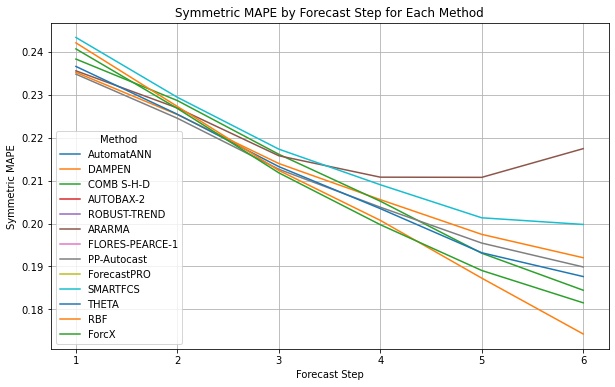

In [48]:
plt.figure(figsize=(10, 6))

# Iterate through each method and plot it
for method in methods:
    method_data = test3[test3['Method'] == method]
    # Group by 'ForecastStep' and calculate the mean 'symmetric_MAPE' for each step
    mean_smape_by_step = method_data.groupby('ForecastStep')['symmetric_MAPE'].mean()
    plt.plot(mean_smape_by_step.index, mean_smape_by_step, label=method)

plt.xlabel('Forecast Step')
plt.ylabel('Symmetric MAPE')
plt.title('Symmetric MAPE by Forecast Step for Each Method')
plt.legend(title='Method')
plt.grid(True)
plt.show()